<a href="https://colab.research.google.com/github/osamja/zero-to-hero/blob/main/makemore_bigram_lm_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this exercise is to reproduce the makemore bigram language model.  

names.txt is an input of names, and we want to produce likely characters using a bigram language modual.  Essentially, let's test our understanding of https://www.youtube.com/watch?v=PaCmpygFfXo by trying to re-implement what we just watched by scratch and asking lots of questions along the way



Cheatsheet: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part1_bigrams.ipynb

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import string
import torch

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/Machine_Learning/makemore/names.txt', 'r') as f: 
    names = f.read().splitlines()

In [ ]:
# lets try to put this into a neural network using a bigram model
limited_names = names[:10]  
first_name = names[0]
# name_set = limited_names    # dev testing
name_set = names              # prod testing

In [ ]:
# create a bigram count model for each pair of characters

# set of possible characters
char_set = sorted(list(set(string.ascii_lowercase)))

In [ ]:
# character to index mapping
stoi = {s:i for i,s in enumerate(char_set)}
stoi['.'] = 26

# index to character mapping
itos = {i:s for s,i in stoi.items()}

In [ ]:
# lets use a 2D np array to store this

char_counts = np.zeros((27, 27))

def count_char_pairs(name, char_counts):
  name = ['.'] + list(name) + ['.']
  for char, next_char in zip(name, name[1:]):
    char_counts[stoi[char], stoi[next_char]] += 1
  
  return name, char_counts

def test_char_counts():
  test_name = 'emma'
  tested_char_counts = np.zeros((28, 28))
  test_name, tested_char_counts = count_char_pairs(test_name, tested_char_counts)
  assert(tested_char_counts[26,4] == 1)
  assert(tested_char_counts[12,12] == 1)
  assert(tested_char_counts[12,0] == 1)
  assert(tested_char_counts[0,26] == 1)
  assert(tested_char_counts[0,0] == 0)
  assert(tested_char_counts[1,2] == 0)


for name in name_set:
  count_char_pairs(name, char_counts)

test_char_counts()

(-0.5, 26.5, 26.5, -0.5)

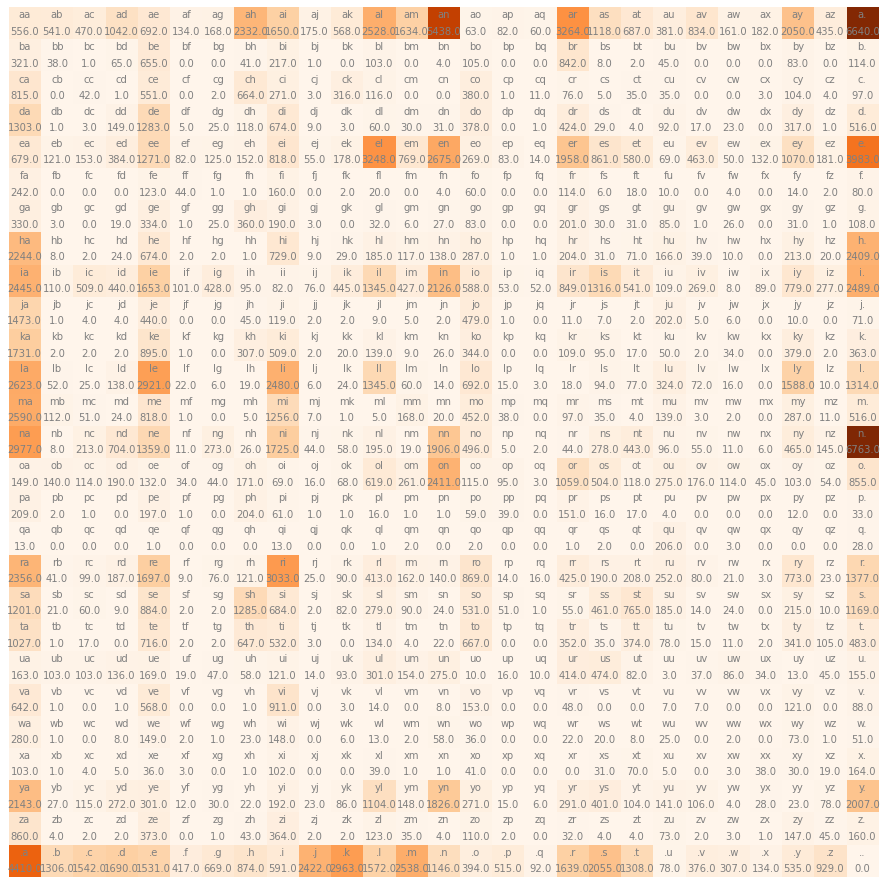

In [ ]:
# visualize our bigram tensor

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(char_counts, cmap='Oranges')

for i in range(char_counts.shape[0]):
  for j in range(char_counts.shape[1]):
    ch_pair = itos[i] + itos[j]
    plt.text(j, i-.1, ch_pair, ha="center", va="bottom", color="gray")
    plt.text(j, i+0.1, char_counts[i, j], ha="center", va="top", color="gray")
plt.axis('off')

Text(0.5, 1.0, 'Starting name letter probabilities')

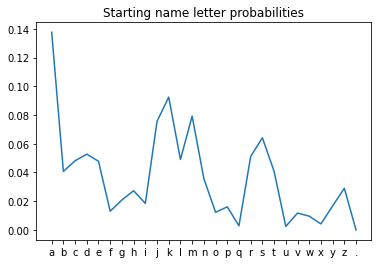

In [ ]:
# sampling from the model

# get probabilities for starting characters
starting_ch_pr = (char_counts[26] / char_counts[26].sum())
char_idx = np.arange(27)
char_arr = [itos[ch] for ch in char_idx]
plt.plot(char_arr, starting_ch_pr)
plt.title('Starting name letter probabilities')

Text(0.5, 1.0, 'sampled starting name letter counts')

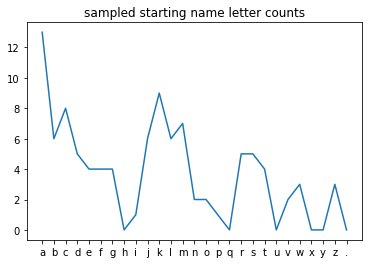

In [ ]:
# now lets sample some starting characters according from this distribution above
sample_char_indices = np.random.multinomial(100, pvals=starting_ch_pr)
plt.plot(char_arr, sample_char_indices)
plt.title('sampled starting name letter counts')

In [ ]:
# now lets run makemore. start sampling characters until our end character (.) is reached

for i in range(5):
  makemore = ''
  ix = 26 # starting character .
  while True:
    ch_prs = char_counts[ix]
    ch_prs = ch_prs / ch_prs.sum()
    ix = np.where(np.random.multinomial(1, pvals=ch_prs) == 1)[0][0]
    makemore += itos[ix]

    if (ix == 26):
      break

  print(makemore)

ce.
mams.
soron.
joniyniair.
kynn.


In [ ]:
# lets increase the efficiency of calculating our probabilities
char_counts.shape
N = char_counts.copy()
model_smoothing = 1
N += model_smoothing

In [ ]:
expected_probs = N[0] / N[0].sum()
N_sums = (N @ np.ones((N.shape[0], 1)))
P = (N) / N_sums
P.shape

(27, 27)

In [ ]:
# now lets run makemore. start sampling characters until our end character (.) is reached

for i in range(5):
  makemore = ''
  ix = 26 # starting character .
  while True:
    ix = np.where(np.random.multinomial(1, pvals=P[ix]) == 1)[0][0]
    makemore += itos[ix]

    if (ix == 26):
      break

  print(makemore)

variareannelasen.
genilidah.
ia.
x.
cacaronyaronanisi.


In [ ]:
# now that we can make more names, lets see if we can calculate the loss for these names

nll = 0
n = 0

for name in names:
  name = ['.'] + list(name) + ['.']
  for ch1, ch2 in zip(name, name[1:]):
    pr_ch1_ch2 = P[stoi[ch1], stoi[ch2]]
    nll += -np.log(pr_ch1_ch2)
    n+=1

print(f'normalized name length loss or average loss: {(nll / n):.4f}')

normalized name length loss or average loss: 2.4546


normalized name length loss or average loss: 2.4546

In [ ]:
P.shape

(27, 27)

In [ ]:
# Instead of sampling for the next character, lets use a neural network
# Initially, this nn will be bad, but we can teach it with the probabibility
# distribution as ground truth for its loss fn

# create the training set of bigrams (x,y)
xs, ys = [], []

for name in names[:1]:
  name = ['.'] + list(name) + ['.']
  for ch1, ch2 in zip(name, name[1:]):
    ix1, ix2 = stoi[ch1], stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
    
xs, ys = torch.tensor(xs), torch.tensor(ys)

In [ ]:
# in order to feed our input vector of starting characters through our neural network,
# we'll use one hot encoding to transform an integer (starting character) as an 
# encoded vector. Thus after this vector gets multiplied and added, we can decode the 
# result back into a representation that can be mapped to our characters

xs_encoded = torch.nn.functional.one_hot(xs, num_classes=27).float()
xs_encoded.shape


torch.Size([5, 27])

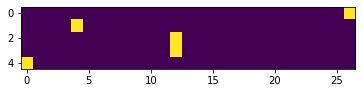

In [ ]:
plt.imshow(xs_encoded)

In [ ]:
xs_encoded.dtype

torch.float32

In [ ]:
W = torch.randn((27,27))
xs_encoded.shape

torch.Size([5, 27])

In [ ]:
logits = (xs_encoded @ W)   # this will eventually represent "log counts" as we keep training and W improves
counts = logits.exp()       # probabilities must be positive
pr_dist = counts / counts.sum(1, keepdims=True)   # probabilities must be between 0 and 1 and sum to 1

pr_dist.shape

# hmm how do we calculate loss without counting the bigrams?
# Let's determine the predicted second character for our first letter (.e)

# ok so lets get the Pr of (x, y)

# xs,ys = ch1,ch2

# lets decode to xs_encoded to get xs/ch1
# xs_encoded[0] is a one hot encoded vector [1 0 0 0 0 ... ] for representing (.)
# Lets get the index of xs_encoded where it eqals one which should be 0
i = 0   # represents the ith char pair in name. aka 0 is the first/second char pair (.em)
ch1_index = torch.topk(xs_encoded[i], 1).indices.item() # decode one hot vector
ch1 = itos[ch1_index]     # xs[0]

ch2_index = ys[i].item()
ch2 = itos[ch2_index]

# determine whether our Pr(ch1,ch2) was high as we should expect
Pr_of_dote = pr_dist[i][ch2_index]
# pr = pr_dist[0][ch1_index, ch2_index]
print(f'Pr({ch1+ch2}) = {Pr_of_dote:.4f}')

# now lets get our loss from the Pr distribution using log, nll
log_likelihood = torch.log(Pr_of_dote)
nll = -log_likelihood
print(f'loss {nll}')



Pr(.e) = 0.0104
loss 4.566159248352051


In [ ]:
# Now lets get the loss for the char pairs of emma
loss = 0.0
num_ch_pairs = 0.0
for i, char in enumerate(xs_encoded):
  ch1_index = torch.topk(xs_encoded[i], 1).indices.item()
  ch1 = itos[ch1_index]

  ch2_index = ys[i].item()
  ch2 = itos[ch2_index]

  pr_ch1_ch2 = pr_dist[i][ch2_index]
  nll = -torch.log(pr_ch1_ch2).item()
  loss += nll
  num_ch_pairs += 1
  print(f'pr_bigram: {pr_ch1_ch2}')

loss = loss / num_ch_pairs    # normalize loss for name length

print(f'\nloss: {loss}\n')


pr_bigram: 0.010397817939519882
pr_bigram: 0.010447898879647255
pr_bigram: 0.030768582597374916
pr_bigram: 0.012567964382469654
pr_bigram: 0.03395142778754234

loss: 4.0736407279968265



loss: 3.5382036685943605 when W is random

In [ ]:
# ok watching YT video, lets do the above operations but instead of
# using a for loop, lets use matrix operations only

# Forward pass and loss using a random weight vector
def get_loss(name):
  xs, ys = [], []
  name = ['.'] + list(name) + ['.']

  # split bigram into xs, ys
  for ch1, ch2 in zip(name, name[1:]):
    ix1, ix2 = stoi[ch1], stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

  xs, ys = torch.tensor(xs), torch.tensor(ys)
  xs_encoded = torch.nn.functional.one_hot(xs, num_classes=27).float()
  

  logits = (xs_encoded @ W)   # this will eventually represent "log counts" as we keep training and W improves
  counts = logits.exp()       # probabilities must be positive
  pr_dist = counts / counts.sum(1, keepdims=True)   # probabilities must be between 0 and 1 and sum to 1

  x_indices = np.arange((xs_encoded.shape[0]))
  pr_bigram = pr_dist[x_indices, ys]
  loss = (-torch.log(pr_bigram)).sum() / len(pr_bigram)
  
  return loss

mean_loss = 0.0

for name in names:
  loss = get_loss(name)
  mean_loss += loss

mean_loss /= len(names)

print(f'mean_loss: {mean_loss}')
# mean_loss: 3.7670795917510986


mean_loss: 3.7670795917510986


In [ ]:
# Ok now lets optimize W using backprop

W = torch.randn((27,27), requires_grad=True)  # initial randomization for weight W

In [ ]:
# ok watching YT video, lets do the above operations but instead of
# using a for loop, lets use matrix operations only

# Forward pass and loss using a random weight vector
def get_loss(name, W):
  xs, ys = [], []
  name = ['.'] + list(name) + ['.']

  # split bigram into xs, ys
  for ch1, ch2 in zip(name, name[1:]):
    ix1, ix2 = stoi[ch1], stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

  xs, ys = torch.tensor(xs), torch.tensor(ys)
  xs_encoded = torch.nn.functional.one_hot(xs, num_classes=27).float()

  logits = (xs_encoded @ W)   # this will eventually represent "log counts" as we keep training and W improves
  counts = logits.exp()       # probabilities must be positive
  pr_dist = counts / counts.sum(1, keepdims=True)   # probabilities must be between 0 and 1 and sum to 1

  x_indices = np.arange((xs_encoded.shape[0]))
  pr_bigram = pr_dist[x_indices, ys]
  loss = (-torch.log(pr_bigram)).sum() / len(pr_bigram)
  
  return loss

mean_loss = 0.0
names_set = names[:1]

for name in names_set:
  loss = get_loss(name, W)
  
  mean_loss += loss

mean_loss /= len(names_set)

print(f'mean_loss for all names: {mean_loss}')  # mean_loss: 3.7670795917510986



mean_loss for all names: 2.4169888496398926


In [ ]:
# init weights
W = torch.randn((27,27), requires_grad=True)  # initial randomization for weight W

In [ ]:
# forward pass
loss = get_loss(names[0])
print(f'loss: {loss}')

loss: 4.390888690948486


In [ ]:
# backward pass
W.grad = None
loss.backward()

In [ ]:
step_size = 0.1
W.data -= W.grad * step_size

In [ ]:
num_iters = 1000

loss_counts = []

for iter in range(num_iters):
  # forward pass
  loss = get_loss(names[0]) # optimize W for emma only
  loss_counts.append(loss.item())
  # print(f'loss: {loss}')

  # backward pass
  W.grad = None
  loss.backward()
  step_size = 0.1
  W.data -= W.grad * step_size

Text(0, 0.5, 'Loss')

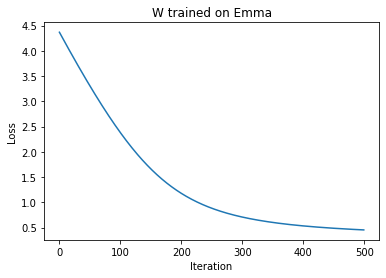

In [ ]:
# lets visualize our gradient descent optimization
plt.plot(loss_counts)
plt.title('W trained on Emma')
plt.xlabel('Iteration')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

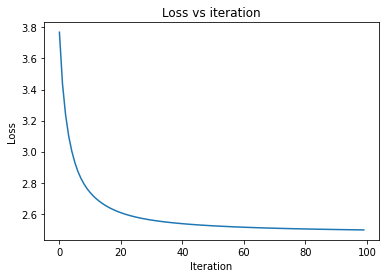

In [ ]:
# Now lets train on all the names

def train(name_set, num_iters=100):

  # Get loss for bigram (x,y)
  def get_loss(xs_encoded, ys, W):
    logits = (xs_encoded @ W)   # this will eventually represent "log counts" as we keep training and W improves
    counts = logits.exp()       # probabilities must be positive
    pr_dist = counts / counts.sum(1, keepdims=True)   # probabilities must be between 0 and 1 and sum to 1
    x_indices = np.arange((xs_encoded.shape[0]))
    pr_bigram = pr_dist[x_indices, ys]
    loss = (-torch.log(pr_bigram)).sum() / len(pr_bigram)
    return loss

  # create encoded bigram dataset
  xs, ys = [], []
  
  for name in name_set:
    name = ['.'] + list(name) + ['.']
    # split bigram into xs, ys
    for ch1, ch2 in zip(name, name[1:]):
      ix1, ix2 = stoi[ch1], stoi[ch2]
      xs.append(ix1)
      ys.append(ix2)

  xs, ys = torch.tensor(xs), torch.tensor(ys)
  xs_encoded = torch.nn.functional.one_hot(xs, num_classes=27).float()
  W = torch.randn((27,27), requires_grad=True)  # initialize weights
  loss_counts = []

  for iter in range(num_iters):
    
    smoothing_factor = .01     # increasing this smoooths the model to minimize W to min loss
    regularization = smoothing_factor * (W**2).mean()

    loss = get_loss(xs_encoded, ys, W) + regularization

    # loss /= len(name_set)
    loss_counts.append(loss.item())

    # backward pass
    W.grad = None
    loss.backward()
    step_size = 40
    W.data -= W.grad * step_size

  return loss_counts, W

loss_counts, W = train(names, num_iters=100)
plt.plot(loss_counts)
plt.title('Loss vs iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [ ]:
min(loss_counts)

2.4956746101379395

In [ ]:
(W**2).sum()

tensor(1273.2903, grad_fn=<SumBackward0>)

In [ ]:
# sample from neural network
makemore = '.'
starting_index = torch.tensor(stoi[makemore])
xs_encoded = torch.nn.functional.one_hot(starting_index, num_classes=27).float()


In [ ]:
def get_pr_dist(xs_encoded, W):
  logits = (xs_encoded @ W)   # this will eventually represent "log counts" as we keep training and W improves
  counts = logits.exp()       # probabilities must be positive
  pr_dist = counts / counts.sum()   # probabilities must be between 0 and 1 and sum to 1
  return pr_dist
  
pr_dist = get_pr_dist(xs_encoded, W)


In [ ]:
pr_dist

tensor([0.1373, 0.0406, 0.0479, 0.0525, 0.0476, 0.0130, 0.0208, 0.0272, 0.0184,
        0.0753, 0.0922, 0.0489, 0.0789, 0.0356, 0.0123, 0.0161, 0.0036, 0.0509,
        0.0639, 0.0406, 0.0032, 0.0118, 0.0096, 0.0044, 0.0167, 0.0289, 0.0017],
       grad_fn=<DivBackward0>)

In [ ]:
# lets sample from this distribution


def makemore():
  makemore = ''
  sample_char_index = torch.tensor(stoi['.'])

  while True:
    xs_encoded = torch.nn.functional.one_hot(sample_char_index, num_classes=27).float()
    pr_dist = get_pr_dist(xs_encoded, W)
    sample_char_index = torch.multinomial(pr_dist, num_samples=1, replacement=True)[0]
    sample_char = itos[sample_char_index.item()]

    makemore += sample_char
    
    if sample_char_index == 26:
      break

  return makemore

for i in range(10):
  print(makemore())

mud.
lyyiwarxpn.
tti.
sikxamamimieynndenal.
a.
za.
aletyolyn.
kah.
kin.
drnn.
